# Initial Imports and constants

In [897]:
import numpy as np
import matplotlib.pyplot as plt
import lightkurve as lk
from lightkurve import search_targetpixelfile
import pandas as pd
import os
import batman
from scipy.stats import norm
import matplotlib

In [898]:
### Define data directory
data_dir = "/Users/pentrican10/Projects/Data/k2-19-data"

### switch to mask out transits
mask_transits = True

### set range for search: [#hours] * [days per hour]
ttv_hour = 2* 0.0416667 # 1 hour to days

# BLS Fit
TESS data

In [899]:
# Download the light curve data
lc = lk.search_lightcurve("K2-19",author = 'SPOC').download_all()

# Flatten the light curve
lc = lc.stitch().flatten(window_length=901).remove_outliers()
#lc.plot()
time = lc.time
flux=lc.flux
flux_err = lc.flux_err

In [900]:
### perform periodigram for planet b
### Create array of periods to search
period = np.linspace(1, 20, 10000)

### Create a BLSPeriodogram
bls = lc.to_periodogram(method='bls', period=period, frequency_factor=500)
#bls.plot()

period_b_bls = bls.period_at_max_power.value
tc_b_bls = bls.transit_time_at_max_power.value
dur_b_bls = bls.duration_at_max_power.value

print(f'Period from BLS: {period_b_bls}')
print(f'TC from BLS: {tc_b_bls}')

Period from BLS: 7.9204920492049204
TC from BLS: 2530.2807708159753


# TESS Transit Times

In [901]:
from scipy.optimize import minimize
from scipy.optimize import root_scalar
from scipy.optimize import least_squares
from scipy.optimize import curve_fit

In [902]:
### read table from Petigura et al. 2020
file = "ajab5220t1_mrt.txt"
def read_table(file_name):
    ### path to table - Petigura et al 2020
    file_path = os.path.join(data_dir, file_name)

    ### Define the column names 
    columns = ["Planet", "Transit", "Inst", "Tc", "e_Tc", "Source"]

    ### Read the text file, specifying space as the delimiter, skipping model_guess_omc rows
    df = pd.read_csv(file_path, delim_whitespace=True, skiprows=22, names=columns)

    ### Remove NaN values
    df = df.dropna()
    return df

df = read_table(file)

/var/folders/69/wlx91x8s1x34mphlfjy0h4pm0000gn/T/ipykernel_14961/3528285165.py:11: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, skiprows=22, names=columns)


In [903]:
### params from exoplanet archive
per_b = 7.9222
rp_b = 0.0777
T14_b = 3.237 * 0.0416667  # convert to days
b_b = 0.17
q1_b = 0.4
q2_b = 0.3

### Get lightcurve data from TESS

In [904]:
### function to convert times from TESS to Petigura offset
TESS_offset = 2457000
petigura_offset = 2454833
def convert_time_t2p(times):
    ### TESS offset 
    BTJD = times + TESS_offset
    new_time = BTJD - petigura_offset
    return new_time

In [905]:
### Download the light curve data
lc = lk.search_lightcurve("K2-19",author = 'SPOC').download_all()
lc = lc.stitch()
if mask_transits == True:
    ### mask transit times before flattening
    #transit_times = [4697.28834658, 4713.12428017, 4721.03972171, 4728.96021376, 4736.88070581, 4744.79614735, 5433.87895563, 5449.71993973]
    transit_times = [4697.28834658, 4713.12933068, 4721.03972171, 4728.96021376, 4736.88070581, 4744.80119786, 5433.87895563, 5449.71993973]
    masked_lc = lc

    times = convert_time_t2p(masked_lc.time.value)

    ### Initialize a mask with all False values (i.e., include all data points initially)
    mask = np.zeros_like(times, dtype=bool)

    ### Iterate through each transit time and update the mask
    for transit_time in transit_times:
        mask |= (times > (transit_time - T14_b/2)) & (times < (transit_time + T14_b/2))

    ### Flatten the masked light curve
    masked_lc = masked_lc.flatten(window_length=901, mask=mask).remove_outliers()
    lc = masked_lc
else:
    ### flatten unmasked lightcurve 
    lc = lc.flatten(window_length=901).remove_outliers()

### Fit for transit times

In [906]:
### initialize guess times (using BLS ephem)
transit_num = [0,2,3,4,5,6,93,95]

tc_guess=[]
for num in transit_num:
    t = tc_b_bls + (num * period_b_bls)
    tc_guess.append(t)

### data from lightcurve 
time_tess = np.array(lc.time.value)
flux=np.array(lc.flux)
flux_err = np.array(lc.flux_err)

time = convert_time_t2p(time_tess)
tc_guess = convert_time_t2p(np.array(tc_guess))
tc_guess = np.array(tc_guess)
print(f'TC guess(TESS): {tc_guess}')

TC guess(TESS): [4697.28077082 4713.12175491 4721.04224696 4728.96273901 4736.88323106
 4744.80372311 5433.88653139 5449.72751549]


In [907]:
### get tc ranges for fit
tc = []
for i in range(len(tc_guess)):
    start = tc_guess[i] - ttv_hour
    end = tc_guess[i] + ttv_hour
    t = np.linspace(start,end, 1000)
    tc.append(t)

In [908]:
### initialize arrays
tc_chi = np.zeros(len(tc))
tc_chi_parabola = np.zeros(len(tc))
ttv = np.zeros(len(tc))
ttv_p = np.zeros(len(tc))
errors = []
errors_p = []

In [909]:
def omc(obs_time, t_num, p, tc):
    calc_time = tc + (t_num* p)
    omc = obs_time - calc_time
    return omc#*24 #days to hours

### Find the intersection points
def intersection_func(t): #masked
    return np.interp(t, tc1, chi_sq) - err_threshold

In [910]:
### plot X^2 vs tc for each guess
for j in range(len(tc)):
    tc1 = tc[j]
    chi_sq = np.zeros(len(tc1))
    chi_sq_lc = np.zeros(len(tc1))
    for i in range(len(tc1)):
        t0_b = 	tc1[i]
        theta_initial = [t0_b, per_b, rp_b, b_b, T14_b, q1_b, q2_b]
        
        ### initialize params
        params = batman.TransitParams()
        params.t0, params.per, params.rp,params.b, params.T14, q1, q2 = theta_initial
        params.u = [2*np.sqrt(q1)*q2, np.sqrt(q1)*(1-2*q2)]  # Limb darkening coefficients
        params.limb_dark = 'quadratic'
        
        ### mask data - extract relevant photometry
        start = tc_guess[j] - ttv_hour
        end = tc_guess[j] + ttv_hour
        mask = (time > (start)) & (time < (end))
        
        transit_model = batman.TransitModel(params, time[mask])
            
        # Generate model light curve
        model_flux = transit_model.light_curve(params)
        
        # Calculate chi-squared value
        sigma2 = flux_err[mask] 
        chi_squared = np.sum(((flux[mask] - model_flux) / sigma2)**2)
        chi_sq[i] = (chi_squared)

    ### masked
    min_chi_time = tc1[np.argmin(chi_sq)]
    min_chi = chi_sq.min()

    tc_chi[j] = min_chi_time
    idx = transit_num[j]
    ttv[j] = min_chi_time - tc_guess[j]

    chi_mask = (chi_sq <= min_chi + 3)
    fit_mask = (chi_sq <= min_chi + 1)

    ### fit parabola to the chisq
    p_chi_sq = np.polyfit(tc1[fit_mask], chi_sq[fit_mask], 2)  

    ### Extract the coefficients   y = ax^2 + bx + c
    a_chi_sq, b_chi_sq, c_chi_sq = p_chi_sq
    
    ### Find the minimum of the parabola xmin = -b/2a from taking derivative=0
    tc_best_fit = -b_chi_sq / (2 * a_chi_sq)
    
    ### Calculate the minimum chi-squared value
    chi_sq_min = a_chi_sq * tc_best_fit**2 + b_chi_sq * tc_best_fit + c_chi_sq
    tc_chi_parabola[j] = tc_best_fit

    ### Calculate the parabola best fit 
    p_1 = a_chi_sq*tc1**2 + b_chi_sq*tc1 + c_chi_sq

    ### calculate ttv from parabola fit 
    ttv_p[j] = tc_best_fit - tc_guess[j]

    ### delta chisq = 1 gives errors
    err_threshold = min_chi + 1 # using chisq discrete minimum
    err_threshold_p = chi_sq_min + 1 # using minimum of parabola
  
    # Find the intersection using root_scalar
    intersections = []
    for k in range(len(tc1) - 1):
        if (chi_sq[k] - err_threshold) * (chi_sq[k + 1] - err_threshold) < 0:
            sol = root_scalar(intersection_func, bracket=[tc1[k], tc1[k + 1]])
            if sol.converged:
                intersections.append((sol.root - min_chi_time))
    errors.append(intersections)

    intersections_p = []
    for k in range(len(tc1) - 1):
        if (p_1[k] - err_threshold_p) * (p_1[k + 1] - err_threshold_p) < 0:
            sol = root_scalar(intersection_func, bracket=[tc1[k], tc1[k + 1]])
            if sol.converged:
                intersections_p.append((sol.root - tc_best_fit))
    errors_p.append(intersections_p)

  
    # plt.plot(tc1[chi_mask], chi_sq[chi_mask],label='chisq')
    # plt.plot(tc1[chi_mask], p_1[chi_mask],label='chisq parabola', color='orange')
    # plt.axvline(x=tc_guess[j], color='r', linestyle='--', label='Bls Guess')
    # plt.axvline(x=min_chi_time, linestyle='--', label='Chisq min')
    # plt.axvline(x=tc1[np.argmin(p_1)], color='orange', linestyle='--', label='Chisq min parabola')

    # # for inter in intersections:
    # #     plt.axvline(x=inter, color='blue', linestyle='--')
    # plt.axhline(y=err_threshold, color='green', linestyle='--', label='Error Threshold')
    # plt.title(f'Transit {j+1}: Planet b')
    # plt.xlabel('tc')
    # plt.ylabel('X^2')
    # plt.legend()
    # plt.show()


In [911]:
#avg the errors   sig^2 = 0.5(sig1^2 + sig2^2)
err_tc_chi = []
for i in range(len(errors)):
    sig = np.sqrt(errors[i][0]**2 + errors[i][1]**2)
    err_tc_chi.append(sig)

err_tc_chi_p = []
for i in range(len(errors_p)):
    sig = np.sqrt(errors_p[i][0]**2 + errors_p[i][1]**2)
    err_tc_chi_p.append(sig)

### Saving Results

In [912]:
# Initialize empty list for storing results
results = []

# Loop through the transits and collect the data dynamically
for j in range(len(tc)):
    # Assuming these variables are calculated inside your loop
    transit = transit_num[j]
    transit_time = tc_chi[j]
    avg_error = err_tc_chi[j]
    ttv_value = ttv[j]
    transit_time_parabola = tc_chi_parabola[j]
    avg_error_parabola = err_tc_chi_p[j]
    ttv_value_parabola = ttv_p[j]
    
    # Create a dictionary for the current row
    row = {
        'Planet': 'k2-19b',
        'Transit': transit,
        'Tc(TESS)': transit_time,
        'Tc_err': avg_error,
        'TTV(TESS)': ttv_value,
        'Tc(TESS) Parabola': transit_time_parabola,
        'Tc_err Parabola': avg_error_parabola,
        'TTV(TESS) Parabola': ttv_value_parabola,
        'Time Offset': 'BJD - 2454833',
        'Period': period_b_bls,
        'Tc_offset': tc_b_bls
    }

    # Append the row to the results list
    results.append(row)

# After the loop, create a DataFrame from the results list
tess_transit_data = pd.DataFrame(results)

# Print the DataFrame to see the collected data
print(tess_transit_data)


   Planet  Transit     Tc(TESS)    Tc_err  TTV(TESS)  Tc(TESS) Parabola  \
0  k2-19b        0  4697.289029  0.004384   0.008258        4697.288910   
1  k2-19b        2  4713.127344  0.002837   0.005589        4713.127453   
2  k2-19b        3  4721.041830  0.003013  -0.000417        4721.041738   
3  k2-19b        4  4728.959653  0.002993  -0.003086        4728.959826   
4  k2-19b        5  4736.880812  0.004142  -0.002419        4736.880952   
5  k2-19b        6  4744.798635  0.002808  -0.005088        4744.798760   
6  k2-19b       93  5433.878774  0.003929  -0.007758        5433.878892   
7  k2-19b       95  5449.720258  0.002277  -0.007257        5449.720286   

   Tc_err Parabola  TTV(TESS) Parabola    Time Offset    Period  \
0         0.004375            0.008139  BJD - 2454833  7.920492   
1         0.002829            0.005698  BJD - 2454833  7.920492   
2         0.003008           -0.000509  BJD - 2454833  7.920492   
3         0.002976           -0.002913  BJD - 2454833  7

# Combine data from TESS, Petigura, and Narita
Assuring same time offsets and ephem

In [913]:
### Petigura data
planet_b_data = df[df["Planet"] == "K2-19b"]
planet_c_data = df[df["Planet"] == "K2-19c"]

petigura_ind = np.array(planet_b_data["Transit"]) 

period_b_petigura = 7.9222 # [days]
tc_b_petigura = 2027.9023 # [days] using petigura offset
period_c_petigura = 11.8993 # [days]
tc_c_petigura = 2020.0007 # [days] using petigura offset

### transit times
tc_petigura_b = np.array(planet_b_data["Tc"])
tc_petigura_c = np.array(planet_c_data["Tc"])

### update index (misalignment in paper indices and tc)
petigura_ind_b_updated = np.array(planet_b_data["Transit"]) - 6
petigura_ind_c_updated = np.array(planet_c_data["Transit"]) - 3

In [914]:
### Narita data
### get Narita et al times (K2)
df_narita = pd.read_csv('narita_times.txt', delim_whitespace=True)
df_narita_b = df_narita[df_narita["planet_num"] == 1]
tc_narita_b = np.array(df_narita_b["Tc"]) - petigura_offset
df_narita_c = df_narita[df_narita["planet_num"] == 2]
tc_narita_c = np.array(df_narita_c["Tc"]) - petigura_offset

### put times into petigura ephem (shift epoch by -6)
narita_ind_b = [-6, -5, -4, -3, -2, -1, 0, 1, 2, 3]
narita_ind_b = np.array(narita_ind_b)
narita_ind_c = [-3, -2, -1, 0, 1, 2, 3]
narita_ind_c = np.array(narita_ind_c)

/var/folders/69/wlx91x8s1x34mphlfjy0h4pm0000gn/T/ipykernel_14961/4284132366.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_narita = pd.read_csv('narita_times.txt', delim_whitespace=True)


In [915]:
### TESS data
### tess times in the paper ephem
tnum_tess = [337,339,340,341,342,343,430,432]

### updated indices for petigura ephem
tess_ind_b = np.array(tess_transit_data["Transit"]) + 337
tc_tess_b = np.array(tess_transit_data["Tc(TESS)"])

In [916]:
### collect all data together
### collect all transit indices
all_transit_num_b = []
for i in range(len(narita_ind_b)):
    all_transit_num_b.append(narita_ind_b[i])
for i in range(len(petigura_ind_b_updated)):
    all_transit_num_b.append(petigura_ind_b_updated[i])
for i in range(len(tess_ind_b)):
    all_transit_num_b.append(tess_ind_b[i])
# print(f"All transit indices: {all_transit_num_b}")

### collect all observed transit times
all_obs_tc_b = []
for i in range(len(tc_narita_b)):
    all_obs_tc_b.append(tc_narita_b[i])
for i in range(len(tc_petigura_b)):
    all_obs_tc_b.append(tc_petigura_b[i])
for i in range(len(tc_tess_b)):
    all_obs_tc_b.append(tc_tess_b[i])
# print(f"All observed transit times: {all_obs_tc_b}")

### collect all observed transit time errors
all_obs_tc_b_err = []
tc_b_err_narita = np.array(df_narita_b["Tc_err"])
tc_b_err_tess = np.array(tess_transit_data["Tc_err"])
tc_b_err_petigura = np.array(planet_b_data["e_Tc"])
for i in range(len(tc_b_err_narita)):
    all_obs_tc_b_err.append(tc_b_err_narita[i])
for i in range(len(tc_b_err_petigura)):
    all_obs_tc_b_err.append(tc_b_err_petigura[i])
for i in range(len(tc_b_err_tess)):
    all_obs_tc_b_err.append(tc_b_err_tess[i])
# print(f"All observed transit times error: {all_obs_tc_b_err}")

### collect all calculated transit times with petigura ephem
all_calc_tc_b = []
for i in range(len(all_transit_num_b)):
    ind = tc_b_petigura + (all_transit_num_b[i] * period_b_petigura)
    all_calc_tc_b.append(ind)
# print(f"All calculated transit times: {all_calc_tc_b}")

### collect all omc
all_omc_b = []
for i in range(len(all_calc_tc_b)):
    omc_ = all_obs_tc_b[i] - all_calc_tc_b[i]
    all_omc_b.append(omc_)
# print(f"All OMC: {all_omc_b}")

all_omc_b_err = all_obs_tc_b_err
# print(f"All OMC err: {all_omc_b_err}")

###########################################################################################################
### collect all values for planet c
### collect all transit indices
all_transit_num_c = []
for i in range(len(narita_ind_c)):
    all_transit_num_c.append(narita_ind_c[i])
for i in range(len(petigura_ind_c_updated)):
    all_transit_num_c.append(petigura_ind_c_updated[i])

# print(f"All transit indices c: {all_transit_num_c}")

### collect all observed transit times
all_obs_tc_c = []
for i in range(len(tc_narita_c)):
    all_obs_tc_c.append(tc_narita_c[i])
for i in range(len(tc_petigura_c)):
    all_obs_tc_c.append(tc_petigura_c[i])

# print(f"All observed transit times c: {all_obs_tc_c}")

### collect all observed transit time errors
all_obs_tc_c_err = []
tc_c_err_narita = np.array(df_narita_c["Tc_err"])
tc_c_err_petigura = np.array(planet_c_data["e_Tc"])
for i in range(len(tc_c_err_narita)):
    all_obs_tc_c_err.append(tc_c_err_narita[i])
for i in range(len(tc_c_err_petigura)):
    all_obs_tc_c_err.append(tc_c_err_petigura[i])
# print(f"All observed transit times error c: {all_obs_tc_c_err}")

### collect all calculated transit times with petigura ephem
all_calc_tc_c = []
for i in range(len(all_transit_num_c)):
    ind = tc_c_petigura + (all_transit_num_c[i] * period_c_petigura)
    all_calc_tc_c.append(ind)
# print(f"All calculated transit times c: {all_calc_tc_c}")

### collect all omc
all_omc_c = []
for i in range(len(all_calc_tc_c)):
    omc_ = all_obs_tc_c[i] - all_calc_tc_c[i]
    all_omc_c.append(omc_)
# print(f"All OMC c: {all_omc_c}")

all_omc_c_err = all_obs_tc_c_err
# print(f"All OMC err c: {all_omc_c_err}")


### Save Results in File

In [917]:
### make txt file with results 
output_file = "ttv_results.txt"

### Combine all data into a structured format
source = ['Narita2015', 'Narita2015', 'Narita2015', 'Narita2015', 'Narita2015', 'Narita2015', 'Narita2015', 'Narita2015', 'Narita2015', 'Narita2015', # b
          'Petigura2020', 'Petigura2020', 'Petigura2020', 'Petigura2020', 'Petigura2020', 'Petigura2020', # b
          'TESS', 'TESS', 'TESS', 'TESS', 'TESS', 'TESS', 'TESS', 'TESS', # b
          'Narita2015', 'Narita2015', 'Narita2015', 'Narita2015', 'Narita2015', 'Narita2015', 'Narita2015', # c
          'Petigura2020', 'Petigura2020'] # c

instrument = ['K2', 'K2', 'K2', 'K2', 'K2', 'K2', 'K2', 'K2', 'K2', 'K2', # b
          'FLWO', 'TRAPPIST', 'MuSCAT', 'Spitzer', 'LCO', 'Spitzer',  # b
          'TESS', 'TESS', 'TESS', 'TESS', 'TESS', 'TESS', 'TESS', 'TESS', # b
          'K2', 'K2', 'K2', 'K2', 'K2', 'K2', 'K2', # c
          'Spitzer', 'Spitzer'] # c

planet_number = []
for i in range(len(all_obs_tc_b)):
    planet_number.append(1)
for i in range(len(all_obs_tc_c)):
    planet_number.append(2)

all_transit_num = [] 
for i in range(len(all_transit_num_b)):
    all_transit_num.append(all_transit_num_b[i])
for i in range(len(all_transit_num_c)):
    all_transit_num.append(all_transit_num_c[i])

all_obs_tc = []
for i in range(len(all_obs_tc_b)):
    all_obs_tc.append(all_obs_tc_b[i])
for i in range(len(all_obs_tc_c)):
    all_obs_tc.append(all_obs_tc_c[i])

all_obs_tc_err = []
for i in range(len(all_obs_tc_b_err)):
    all_obs_tc_err.append(all_obs_tc_b_err[i])
for i in range(len(all_obs_tc_c_err)):
    all_obs_tc_err.append(all_obs_tc_c_err[i])

all_omc = []
for i in range(len(all_omc_b)):
    all_omc.append(all_omc_b[i])
for i in range(len(all_omc_c)):
    all_omc.append(all_omc_c[i])

### Ensure source and instrument are numpy arrays with dtype=object
source = np.array(source, dtype=object)
instrument = np.array(instrument, dtype=object)


In [918]:
### save
data_to_save = np.column_stack((planet_number, all_transit_num, all_obs_tc, all_obs_tc_err, all_omc, source, instrument))

### Define header
header = "Planet_num Index Tc Tc_err OMC Source Instrument"

### Save to file
np.savetxt(output_file, data_to_save, fmt='%d %d %.8f %.8f %.8f %s %s', header=header, comments='')

print(f"Results saved to {output_file}")

Results saved to ttv_results.txt


# Jnkepler OMC Fitting

In [919]:
from jax import config, random
import numpyro, jax
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, init_to_value
config.update('jax_enable_x64', True)
numpyro.set_platform('cpu') 
num_chains = 4
numpyro.set_host_device_count(num_chains)
print ('# jax device count:', jax.local_device_count())

from jnkepler.jaxttv import JaxTTV
from jnkepler.jaxttv import ttv_default_parameter_bounds, ttv_optim_curve_fit, scale_pdic
import corner

# jax device count: 4


In [920]:
### Read results
d = pd.read_csv("ttv_results.txt", sep="\s+", header=0, names=['Planet_num', 'Index', 'Tc', 'Tc_err', 'OMC', 'Source', 'Instrument'])


<>:2: SyntaxWarning: invalid escape sequence '\s'
<>:2: SyntaxWarning: invalid escape sequence '\s'
/var/folders/69/wlx91x8s1x34mphlfjy0h4pm0000gn/T/ipykernel_14961/1782444756.py:2: SyntaxWarning: invalid escape sequence '\s'
  d = pd.read_csv("ttv_results.txt", sep="\s+", header=0, names=['Planet_num', 'Index', 'Tc', 'Tc_err', 'OMC', 'Source', 'Instrument'])


In [921]:
### get times, errs from the data
list_of_obs_transit_times = []
list_of_transit_time_errs = []
# period_guess = [7.9222, 11.8993] # rough initial guess to track transit epochs (from Petigura 2020)
period_guess = [7.91975198, 11.90285385]
for j in range(2):
    list_of_obs_transit_times.append(np.array(d.Tc[d.Planet_num==j+1]))
    list_of_transit_time_errs.append(np.array(d.Tc_err[d.Planet_num==j+1]))
index_obs_b = np.array(d.Index[d.Planet_num==1])
index_obs_c = np.array(d.Index[d.Planet_num==2])

tcobs = []
errorobs = []
for j in range(2):
    tcobs.append(np.array(d.Tc[d.Planet_num == j + 1]))
    errorobs.append(np.array(d.Tc_err[d.Planet_num == j + 1]))

In [922]:
### run JaxTTV sim
t_start = 1980.  # start of integration
# t_end = 5500. # end of integration
t_end = 7700.
dt = 0.1 # integration timestep
# jttv = JaxTTV(t_start, t_end, dt, list_of_obs_transit_times, period_guess, errorobs=list_of_transit_time_errs)
jttv = JaxTTV(t_start, t_end, dt, tcobs, period_guess, errorobs=errorobs, print_info=True)

# number of transiting planets:    2
# integration starts at:           1980.00
# first transit time in data:      1980.38
# last transit time in data:       5449.72
# integration ends at:             7700.00
# integration time step:           0.1000 (1/79 of innermost period)



In [923]:
### set bounds for fit
param_bounds = ttv_default_parameter_bounds(jttv, emax=0.25)

### initialize p_init: p1,p2,ecosw1,ecosw2,esinw1,esinw2,tic1,tic2,lnpmass1,lnpmass2
### using best fit for run with all points
p_init = np.array([7.91978264, 11.90381532, -0.12693783, -0.08689699, -0.14793586, -0.17598388, 1980.38363425, 1984.27272612, -9.07538167, -10.13796006])

### fit
popt = ttv_optim_curve_fit(jttv,param_bounds,p_init=p_init, plot=False)
# plt.show()
print(popt)

# running least squares optimization...


/opt/homebrew/anaconda3/lib/python3.12/site-packages/jnkepler/jaxttv/infer.py:97: UserWarning: Bounds for cosi/lnode not provided: assuming coplanar orbits.
  warnings.warn(


# objective function: 44.92 --> 44.92 (33 data)
# elapsed time: 3.4 sec
{'period': array([ 7.91977991, 11.90383163]), 'ecosw': array([-0.12634932, -0.08642707]), 'esinw': array([-0.14745586, -0.17554991]), 'tic': array([1980.38363536, 1984.27272814]), 'lnpmass': array([ -9.0762036 , -10.13875893]), 'pmass': Array([1.14354921e-04, 3.95178166e-05], dtype=float64)}


/opt/homebrew/anaconda3/lib/python3.12/site-packages/jnkepler/jaxttv/jaxttv.py:523: UserWarning: using t0 and P from a linear fit to the observed transit times.
  warnings.warn(


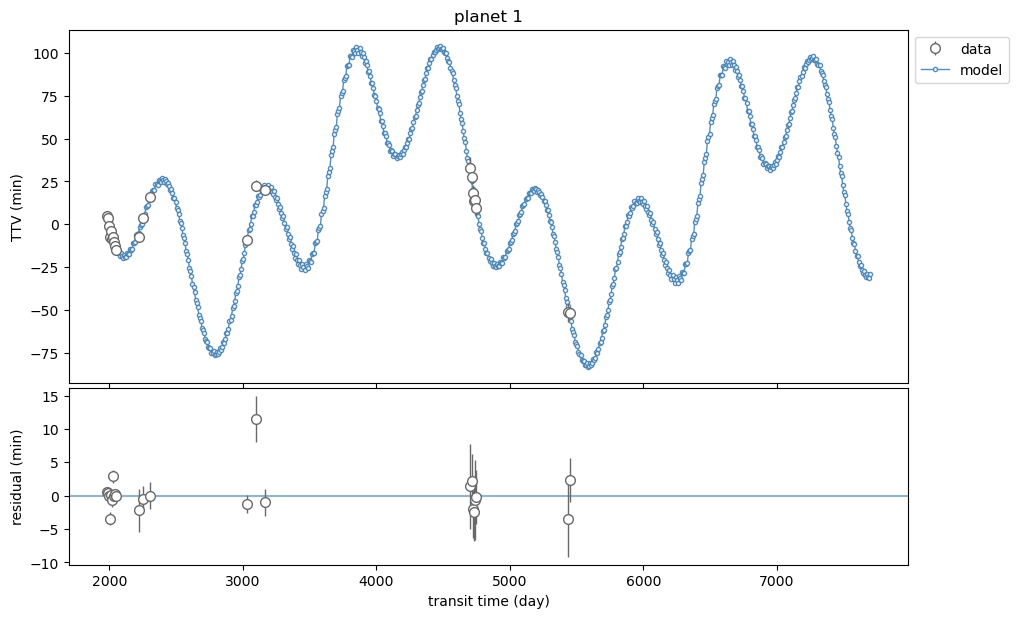

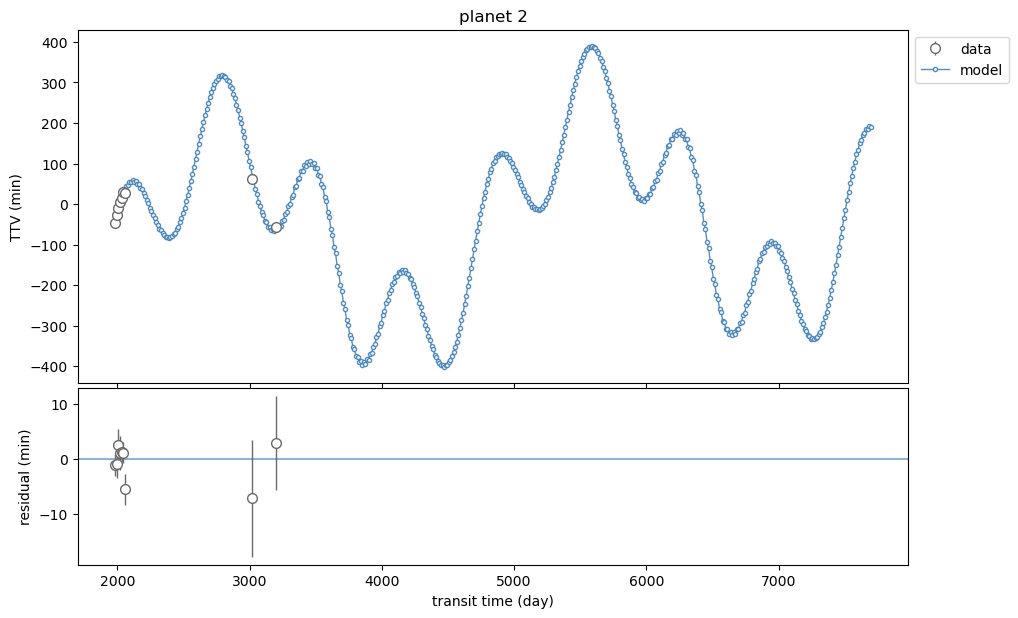

In [924]:
### plot fit
tcall = jttv.get_transit_times_all_list(popt,truncate=False)
jttv.plot_model(tcall, marker='.')
plt.show()

# fractional energy error (symplectic, dt=1.00e-01): -6.86e-09
# fractional energy error (symplectic, dt=7.92e-03): -4.80e-11
# max difference in tc: 4.66e-06 days (0.40 sec)


sample: 100%|█| 1000/1000 [00:00<00:00, 2016.44it/s, 3 steps of size 5.78e-01. a



                mean       std    median      5.0%     95.0%     n_eff     r_hat
      lndf      0.84      0.51      0.76      0.13      1.78    187.42      1.00
     lnvar     -1.05      0.48     -1.10     -1.85     -0.34    196.19      1.00

Number of divergences: 0


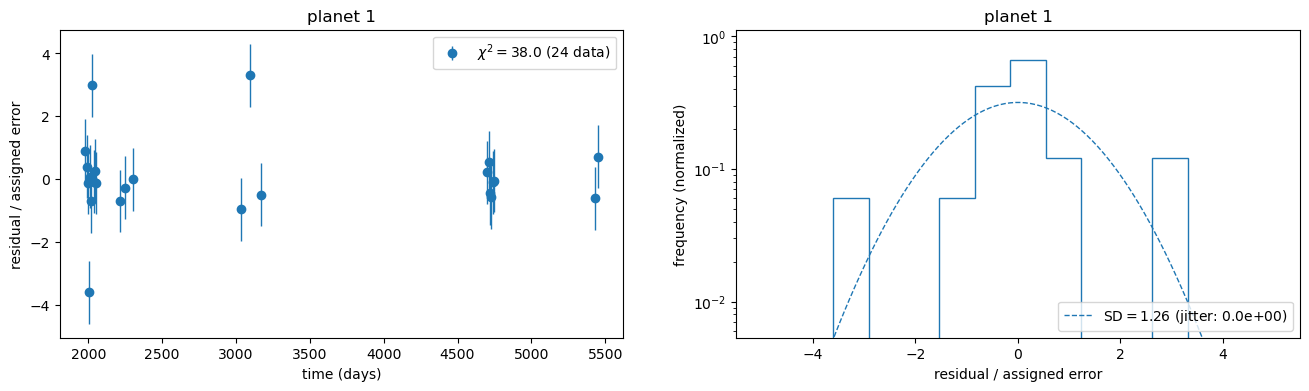

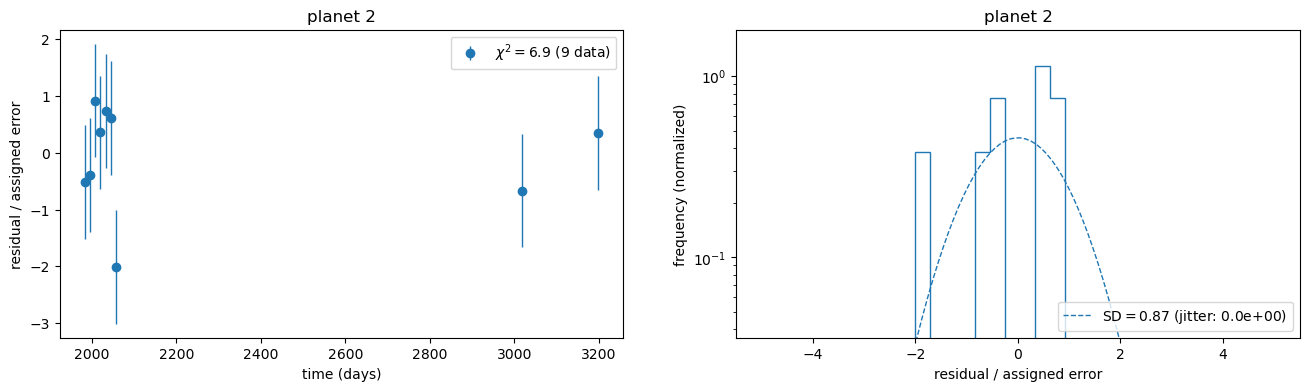

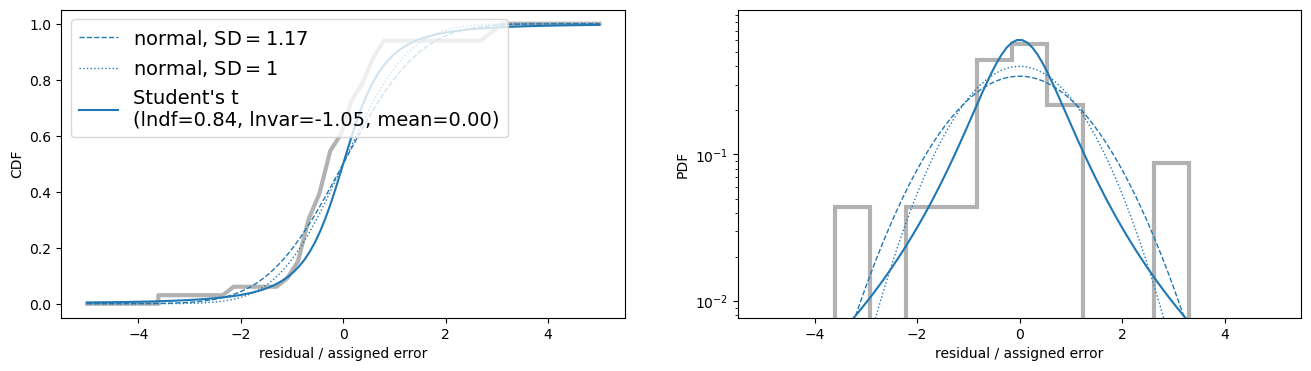

In [925]:
### check precision and residuals 
tc, _ = jttv.check_timing_precision(popt)

pdic_normal, pdic_student = jttv.check_residuals(popt)
plt.show()

# Plot Predicted Times from Petigura2020

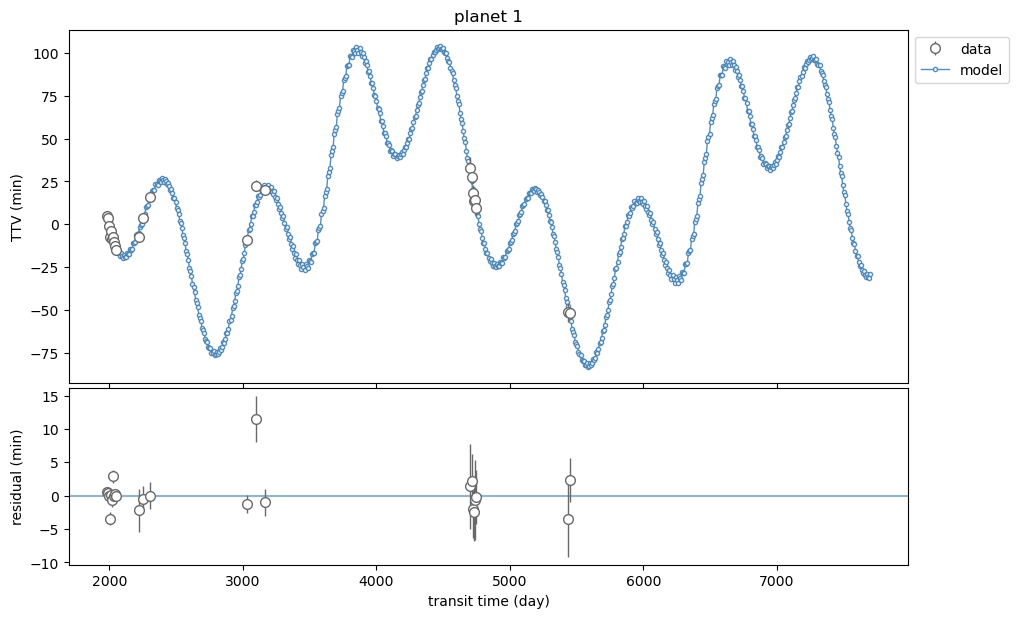

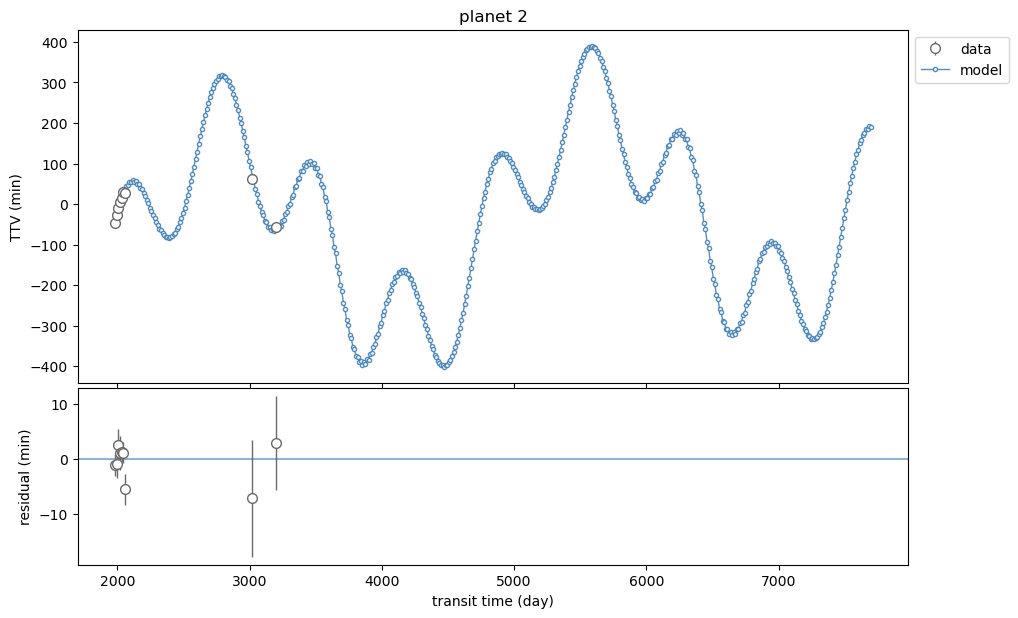

In [926]:
tcall = jttv.get_transit_times_all_list(popt,truncate=False)
jttv.plot_model(tcall, marker='.')
plt.show()

In [927]:
### Predicted times from Petigura2020
file_petigura_predicted_time = 'ajab5220t4_mrt.txt'
def read_table(file_name):
    ### path to table - Petigura et al 2020
    file_path = os.path.join(data_dir, file_name)

    ### Define the column names 
    columns = ["Planet", "Transit","Date", "Tc_pred", "e_Tc_pred"]

    ### Read the text file, specifying space as the delimiter, skipping model_guess_omc rows
    df = pd.read_csv(file_path, delim_whitespace=True, skiprows=17, names=columns)

    ### Remove NaN values
    df = df.dropna()
    return df

df_petigura = read_table(file_petigura_predicted_time)

### separate by planet
df_petigura_b = df_petigura[df_petigura["Planet"] == 'b']
df_petigura_c = df_petigura[df_petigura["Planet"] == 'c']

/var/folders/69/wlx91x8s1x34mphlfjy0h4pm0000gn/T/ipykernel_14961/2072032578.py:11: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, skiprows=17, names=columns)


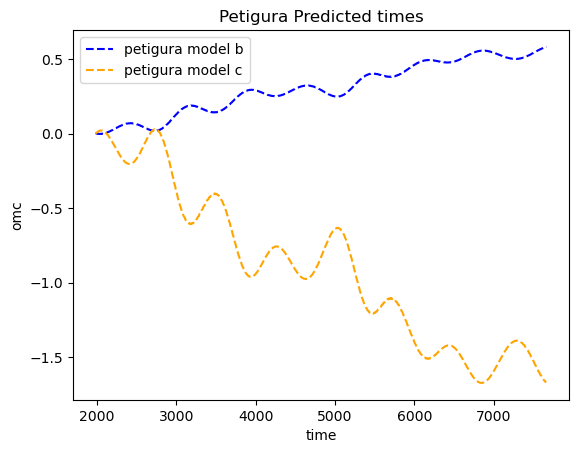

In [939]:
### best fit periods and tc
best_fit_periods = popt['period']
best_fit_tc = popt['tic']
period_b_fit =  best_fit_periods[0]
period_c_fit = best_fit_periods[1]
tc_b_fit = best_fit_tc[0]
tc_c_fit = best_fit_tc[1]

def ephem(p,tc,ind):
    t = tc + (p*ind)
    return t
    
ind_petigura_b = df_petigura_b["Transit"]
ind_petigura_c = df_petigura_c["Transit"]

t_petigura_b = df_petigura_b["Tc_pred"]
t_petigura_c = df_petigura_c["Tc_pred"]

ephem_time_b = ephem(period_b_fit, tc_b_fit, ind_petigura_b)
ephem_time_c = ephem(period_c_fit, tc_c_fit, ind_petigura_c)

ephem_omc_b = t_petigura_b - ephem_time_b
ephem_omc_c = t_petigura_c - ephem_time_c

times = df_petigura["Tc_pred"]
plt.plot(t_petigura_b, ephem_omc_b, label='petigura model b',linestyle='--',c='b')
plt.plot(t_petigura_c, ephem_omc_c, label='petigura model c',linestyle='--',c='orange')
plt.title('Petigura Predicted times')
plt.xlabel('time')
plt.ylabel('omc')
plt.legend()
plt.show()




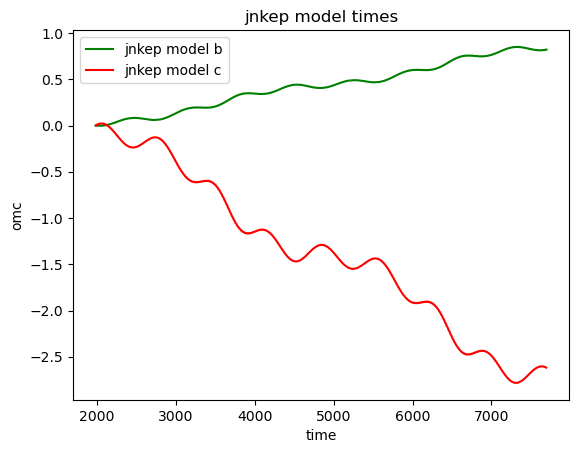

In [940]:
### plot jnkep model omc
t_jnkep_b = tcall[0]
t_jnkep_c = tcall[1]

ind_jnkep_b = np.arange(0,(len(np.array(tcall[0]))), 1)
ind_jnkep_c = np.arange(0,(len(np.array(tcall[1]))), 1)

jnkep_ephem_time_b = ephem(period_b_fit, tc_b_fit, ind_jnkep_b)
jnkep_ephem_time_c = ephem(period_c_fit, tc_c_fit, ind_jnkep_c)

jnkep_omc_b = t_jnkep_b - jnkep_ephem_time_b
jnkep_omc_c = t_jnkep_c - jnkep_ephem_time_c

plt.plot(t_jnkep_b, jnkep_omc_b, label='jnkep model b', c='g')
plt.plot(t_jnkep_c, jnkep_omc_c, label='jnkep model c', c='r')
plt.title('jnkep model times')
plt.xlabel('time')
plt.ylabel('omc')
plt.legend()
plt.show()

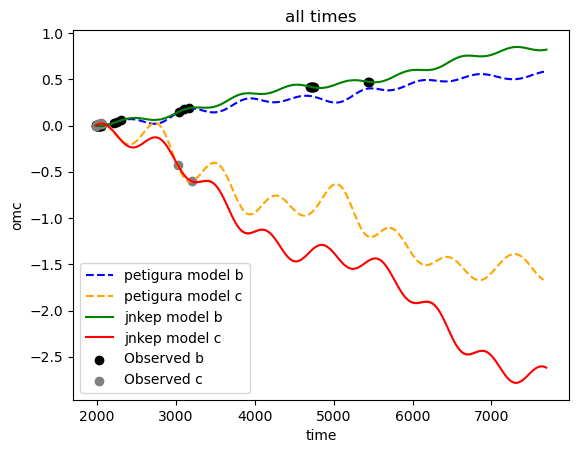

In [938]:
### adding observed data
t_obs_b = tcobs[0]
t_obs_c = tcobs[1]

### same ephem as the model and predictions 
obs_omc_b = t_obs_b - ephem(period_b_fit, tc_b_fit, index_obs_b)
obs_omc_c = t_obs_c - ephem(period_c_fit, tc_c_fit, index_obs_c)


# plt.scatter(t_obs_b, obs_omc_b, label='obs b')
# plt.scatter(t_obs_c, obs_omc_c, label='obs c')
plt.plot(t_petigura_b, ephem_omc_b, label='petigura model b', linestyle='--',c='b')
plt.plot(t_petigura_c, ephem_omc_c, label='petigura model c',linestyle='--',c='orange')
plt.plot(t_jnkep_b, jnkep_omc_b, label='jnkep model b',c='g')
plt.plot(t_jnkep_c, jnkep_omc_c, label='jnkep model c',c='r')
offset_obs_b = omc_obs_b[0]
offset_obs_c = omc_obs_c[0]
plt.scatter(t_obs_b, omc_obs_b-offset_obs_b,marker='o',label='Observed b',c='black')
plt.scatter(t_obs_c, omc_obs_c-offset_obs_c, marker='o', label='Observed c',c='grey')

plt.title('all times')
plt.xlabel('time')
plt.ylabel('omc')
# plt.xlim(1980,3300)
plt.legend()
plt.show()

In [936]:
### estimate the slope of the jnkep model using rise/run of first and last points
b_slope = (jnkep_omc_b[-1] - jnkep_omc_b[0]) / (t_jnkep_b[-1] - t_jnkep_b[0])
print(f'b slope for jnkep model: {b_slope}')

c_slope = (jnkep_omc_c[-1] - jnkep_omc_c[0]) / (t_jnkep_c[-1] - t_jnkep_c[0])
print(f'c slope for jnkep model: {c_slope}')

b slope for jnkep model: 0.00014353983250677034
c slope for jnkep model: -0.00045847547525777337


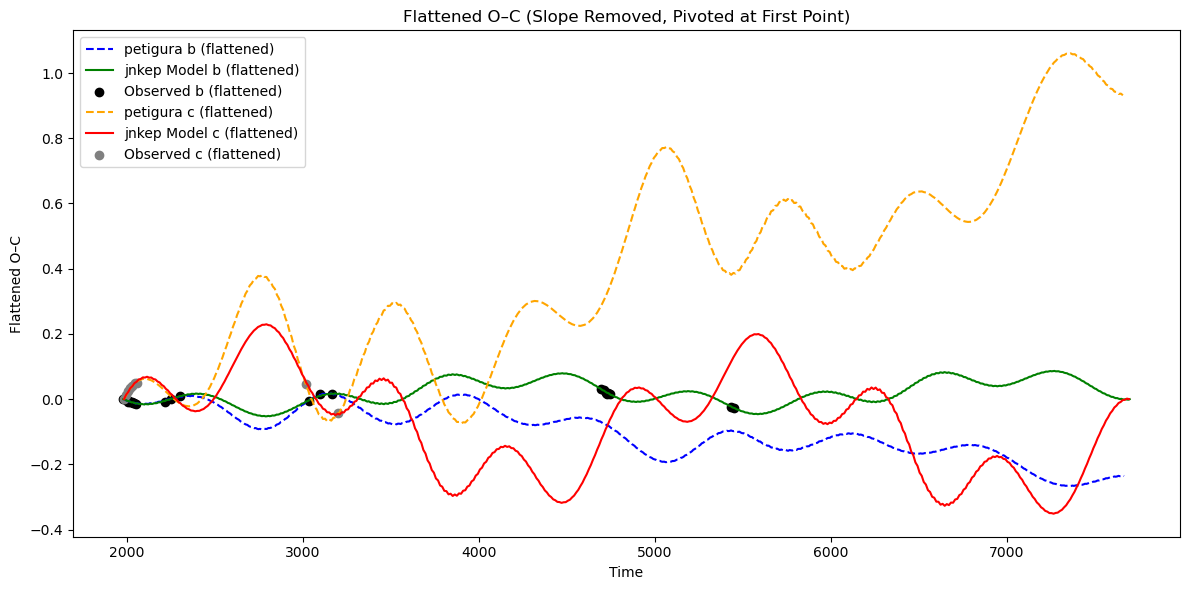

In [941]:
### Fit the linear trend for b and c (using numpy.polyfit)
def apply_trend(t, y, slope):
    # Ensure t and y are NumPy arrays
    t = np.asarray(t)
    y = np.asarray(y)
    # Remove slope, pivot about the first point
    return y - slope * (t - t[0])

### Planet b - Flatten the data
flat_petigura_b = apply_trend(t_petigura_b, ephem_omc_b, b_slope)
flat_jnkep_b = apply_trend(t_jnkep_b, jnkep_omc_b, b_slope)
flat_obs_b = apply_trend(t_obs_b, (omc_obs_b-offset_obs_b), b_slope)

### Planet c - Flatten the data
flat_petigura_c = apply_trend(t_petigura_c, ephem_omc_c, c_slope)
flat_jnkep_c = apply_trend(t_jnkep_c, jnkep_omc_c, c_slope)
flat_obs_c = apply_trend(t_obs_c, (omc_obs_c-offset_obs_c), c_slope)

### Plot flattened data
plt.figure(figsize=(12, 6))

### Plot for Planet b
plt.plot(t_petigura_b, flat_petigura_b, label='petigura b (flattened)', linestyle='--',c='b')
plt.plot(t_jnkep_b, flat_jnkep_b, label='jnkep Model b (flattened)',c='g')
plt.scatter(t_obs_b, flat_obs_b, label='Observed b (flattened)', marker='o', color='black')

### Plot for Planet c
plt.plot(t_petigura_c, flat_petigura_c, label='petigura c (flattened)', linestyle='--',c='orange')
plt.plot(t_jnkep_c, flat_jnkep_c, label='jnkep Model c (flattened)',c='r')
plt.scatter(t_obs_c, flat_obs_c, label='Observed c (flattened)', marker='o', color='gray')

### Customize the plot
plt.title('Flattened O–C (Slope Removed, Pivoted at First Point)')
plt.xlabel('Time')
plt.ylabel('Flattened O–C')
plt.legend()
plt.tight_layout()
plt.show()

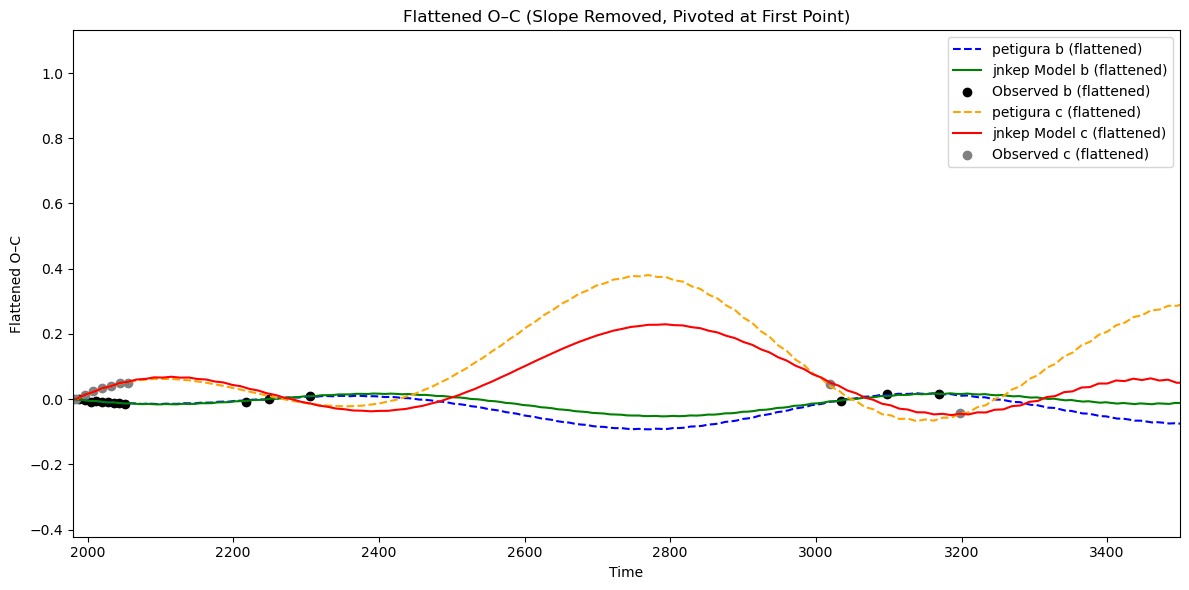

In [942]:
### zoom into section [1980,3500]
### Plot flattened data
plt.figure(figsize=(12, 6))

### Plot for Planet b
plt.plot(t_petigura_b, flat_petigura_b, label='petigura b (flattened)', linestyle='--',c='b')
plt.plot(t_jnkep_b, flat_jnkep_b, label='jnkep Model b (flattened)',c='g')
plt.scatter(t_obs_b, flat_obs_b, label='Observed b (flattened)', marker='o', color='black')

### Plot for Planet c
plt.plot(t_petigura_c, flat_petigura_c, label='petigura c (flattened)', linestyle='--',c='orange')
plt.plot(t_jnkep_c, flat_jnkep_c, label='jnkep Model c (flattened)',c='r')
plt.scatter(t_obs_c, flat_obs_c, label='Observed c (flattened)', marker='o', color='gray')

### Customize the plot
plt.title('Flattened O–C (Slope Removed, Pivoted at First Point)')
plt.xlabel('Time')
plt.ylabel('Flattened O–C')
plt.xlim(1980,3500)
plt.legend()
plt.tight_layout()
plt.show()